Ramsey Fringes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [136]:
# set initial values
p11, p22, p33 = 0.5, 0.5, 0
p12, p13, p23 = 0.5, 0, 0
w1_0, w2_0 = 0.25,0.25
d1, d2 = 0.5, 0
g31, g32 = 0.05, 0.05

t1 = 50
tfree = 50
tmeasure = 1
n_cycles = 2


# initialize other variables

P0 = np.array([p11, p22, p12, p13, p23], dtype='complex')

on = (w1_0, w2_0)
off = (0,0)

t1span = (0, t1)
tfreespan = (0, tfree)

In [137]:
# eoms

'''
P[0] = p11
P[1] = p22
P[2] = p12
P[3] = p13
P[4] = p23
'''

def dP_dt(t, P, w1, w2):
    Pt = np.zeros(5, dtype='complex')
    Pt[0] = 1j * w1 * (np.conj(P[3])-P[3]) + g31*(1-P[0]-P[1])
    Pt[1] = 1j * w2 * (np.conj(P[4])-P[4]) + g32*(1-P[0]-P[1])
    Pt[2] = 1j * ((d1+d2)*P[2] + w1*np.conj(P[4]) - w2*P[3])
    Pt[3] = 1j * (d1*P[3] + w1*(1-P[1]-2*P[0]) - w2*(P[2]))
    Pt[4] = 1j * (-1*d2*P[4] + w2*(1-P[0]-2*P[1]) - w1*np.conj(P[2]))
    return Pt


In [138]:
def ramsey(P, first_step, max_step):
    
    P_measured = np.zeros(5, dtype='complex')
    P_curr = np.zeros(5, dtype='complex')
    for i in range(5):
        P_curr[i] = P[i]
    
    # pulse
    result = solve_ivp(dP_dt, t1span, P_curr, args=on, t_eval=[tmeasure, t1], first_step=first_step, max_step=max_step)
    for j in range(5):
        P_measured[j] = result.y[j, 0]
        P_curr[j] = result.y[j, 1]
    
    # free evolution
    result = solve_ivp(dP_dt, tfreespan, P_curr, args=off, t_eval=[tfree], first_step=first_step, max_step=max_step)
    for j in range(5):
        P_curr[j] = result.y[j, 0]
        
    return P_measured, P_curr

In [139]:
def repeat_cycle(P_start, n):
    
    P_curr = np.zeros(5, dtype='complex')
    for i in range(5):
        P_curr[i] = P_start[i]
    
    measure11 = np.zeros(n, dtype='complex')
    measure22 = np.zeros(n, dtype='complex')
    
    for i in range(n):
        pops = ramsey(P_curr, 0.25, 10)
        measure11[i] = pops[0][0]
        measure22[i] = pops[0][1]
        P_curr = pops[1]
        
    measure33 = np.subtract(np.ones(n), np.add(measure11, measure22))
    
    return measure33

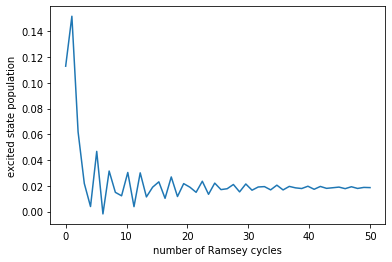

In [140]:
n_cycles = 50
pop33 = repeat_cycle(P0, n_cycles)

t = np.linspace(0, n_cycles, n_cycles)
plt.xlabel("number of Ramsey cycles")
plt.ylabel("excited state population")
plt.plot(t, pop33.real)


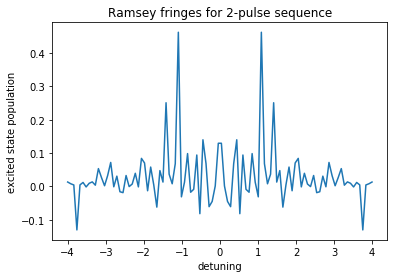

In [141]:
n_cycles = 40
d1, d2 = 4, 0
n = 100
d1_0 = np.linspace(-1*d1, d1, num=n)
pop33_avg = np.zeros(n)
for i in range(n):
    d1 = d1_0[i]
    pop33 = repeat_cycle(P0, n_cycles)
    last = pop33[int(n_cycles*0.6):]
    pop33_avg[i] = sum(last.real)/len(last)

plt.xlabel("detuning")
plt.ylabel("excited state population")
plt.title('Ramsey fringes for 2-pulse sequence')
plt.plot(d1_0, pop33_avg.real)